In [ ]:
import os
import sys
sys.path.append('..')
import torch
import librosa
from scipy.io import wavfile
from IPython import display as disp
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.modules import VocosVocoderModule

/home/grads/q/quamer.waris/anaconda3/envs/xarts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Set the GPU device
MAX_WAV_VALUE = 32768.0

In [12]:
model = VocosVocoderModule.load_from_checkpoint(
    '../ckpts/epoch=3.ckpt',
    map_location="cpu",
)

/home/grads/q/quamer.waris/anaconda3/envs/xarts/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [14]:
wav_file = "../sample_wav/BDL/arctic_a0001.wav"
_device = "cpu"
sample_rate = 16000

audio, _ = librosa.load(wav_file, sr=sample_rate)

disp.Audio(audio, rate=16000)

In [15]:
audio = torch.from_numpy(audio).unsqueeze(0).unsqueeze(0).to(_device)
mel_spec = model.feature_extractor(audio)

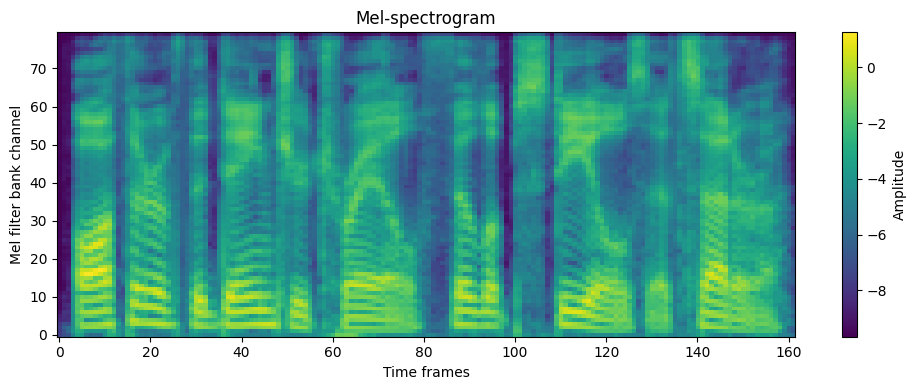

In [ ]:
# mel: torch.Tensor of shape (80, T)
mel_np = mel_spec.squeeze().cpu().numpy()  # -> (80, T)

plt.figure(figsize=(10, 4))
plt.imshow(mel_np, aspect='auto', origin='lower')
plt.xlabel('Time frames')
plt.ylabel('Mel filter bank channel')
plt.title('Mel‑spectrogram')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


In [25]:
# mel to wav
with torch.no_grad():
    audio_out = model(mel_spec)
    audio_out = audio_out.squeeze().cpu().numpy()
    # audio_out = audio_out * MAX_WAV_VALUE
    # audio_out = audio_out.astype('int16')

disp.Audio(audio_out, rate=16000)

In [31]:
# streaming generation
chunk_size = 8
with torch.no_grad(), model.decoder[0].streaming(1), model.decoder[0].streaming(1):
    audio_out_stream = []
    for mel in tqdm(mel_spec.split(chunk_size, dim=2)):
        audio_out_stream.append(model(mel))
    audio_out_stream = torch.cat(audio_out_stream, dim=2).squeeze().cpu().numpy()

disp.Audio(audio_out_stream, rate=16000)

100%|██████████| 21/21 [00:00<00:00, 33.08it/s]
